In [1]:
import os
import pickle
import datetime

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

import tensorflow as tf
import madmom

from segment import segment_spectrogram
from modules.labels import get_label_vector
from modules.madmom_cnn_prep import cnn_preprocessor
from datasets import Dataset
from analyze_detection import evaluate, f_score
from models.bock2013pret import get_model

%load_ext autoreload
%autoreload 2

SR = 44100
HOP = 441
CONTEXT = 7


In [2]:
# Load Madmom normalization
def cnn_normalize(frames):
    inv_std = np.load("models/bock2013pret_inv_std.npy")
    mean = np.load("models/bock2013pret_mean.npy")
    frames_normalized = (frames - np.reshape(mean, (1,80,3)))*np.reshape(inv_std, (1,80,3))
    return frames_normalized
    
# Load preprocessing funciton
preprocessor = cnn_preprocessor()
box_processor = madmom.features.onsets.CNNOnsetProcessor()

In [3]:
ds = Dataset("initslurtest")
audio_fnames = ds.get_audio_paths()
label_fnames = ds.get_annotation_paths()

audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [genfromtxt(label_fname, delimiter=',') for label_fname in label_fnames]
for ele in sample_rates:
    if ele != SR:
        print("Some sample rates are not equal to 44.1kHz!")


Dataset created
Found 19 audio files and 0 annotation files.


/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [ ]:
[print("Name of rec: {}\n"
       "Len in seconds: {:.2f}\n"
       "Shape of audio: {}\n"
       "Shape of onset schedule: {}\n"
       "Onsets from {:.2f}s to {:.2f}s\n".format(
                                        os.path.split(fname)[1], 
                                        audio.shape[0]/44100,
                                        audio.shape,
                                        schedule.shape,
                                        schedule.min(),
                                        schedule.max(),
                                        ) 
    ) for fname, audio, schedule in zip(audio_fnames, audios, onset_schedules)
]

In [ ]:
# Add white noise to recordings
# Noise variance is adjusted to a fixed Signal Noise Ratio computed recording-wise
# snr_db = 20 means S/N=10
# snr_db = 10 means S/N≈3.2
SNR_DB = 10
snr_v = 10**(SNR_DB/20)

def augmentation(audio, t=None, p=None):
    if t==None:
        return audio
    elif t=="white_noise":
        # p contains snr_db parameter
        return audio+np.random.normal(
            scale=np.mean(rms(y=audio))/(10**(p/20)),
            size=audio.shape
            )

noisy_audios = [augmentation(audio, t="white_noise", p=SNR_DB) for audio in audios]
fig, axs = plt.subplots(2,1)
axs[0].plot(audios[0][:100000])
axs[1].plot(noisy_audios[0][:100000])

In [4]:
onset_vectors = [get_label_vector(sched, len(audio)/SR, HOP, SR)
    for (sched, audio) in zip(onset_schedules, audios)
]
print(onset_vectors[0].shape)

(1697,)


In [5]:
# Create data and normalize
mm_proc_frames = [preprocessor(fname) for fname in audio_fnames]
mm_frames_normalized = [cnn_normalize(frame_set) for frame_set in mm_proc_frames]
print(mm_frames_normalized[0].shape)
X = [[
    data[i-CONTEXT:i+CONTEXT+1,:,:] 
    for i in range(CONTEXT, data.shape[0]-CONTEXT)
] for data in mm_frames_normalized]
X = [np.transpose(np.stack(data, 0), [0,2,1,3]) for data in X]
print(X[0].shape)

(1711, 80, 3)
(1697, 80, 15, 3)


In [7]:
# Single split:

from sklearn.model_selection import train_test_split
random_seed = 119
test = 0.1
validation = 0.2
training = 0.7
train_idx, test_val_idx = train_test_split(np.arange(len(audio_fnames)), test_size=test+validation, random_state=random_seed)
val_idx, test_idx = train_test_split(test_val_idx, test_size=test/(test+validation), random_state=random_seed)
idx_split = [train_idx, val_idx, test_idx]
print(idx_split)

# Divide
X_train, X_val, X_test = [
    np.concatenate([X[i] for i in idx]) 
    for idx in idx_split
]
y_train, y_val, y_test = [
    np.concatenate([onset_vectors[i] for i in idx]) 
    for idx in idx_split
]

train_onset_ratio = y_train.sum()/len(y_train)

# Normalize
center_frames_train = X_train[:,:,7,:]
mean_train = center_frames_train.mean(0).reshape((1,80,1,3))
std_train = center_frames_train.std(0, ddof=1).reshape((1,80,1,3))

X_train = (X_train - mean_train)/std_train
X_val = (X_val - mean_train)/std_train
X_test = (X_test - mean_train)/std_train

[array([ 0, 15, 13,  8, 14,  4,  7,  9,  6, 10, 17, 18,  2]), array([11, 16,  1,  3]), array([12,  5])]


In [6]:
# K-Fold:

from sklearn.model_selection import KFold
random_seed = 119
n_splits =  5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=True)
kf_gen = kf.split(np.arange(len(audio_fnames)))
for train_index, test_index in kf_gen:
    print("Train: ", train_index, "Test: ", test_index)
kf_gen = kf.split(np.arange(len(audio_fnames)))


Train:  [ 0  1  2  4  5  7  8  9 11 12 13 14 16 17 18] Test:  [ 3  6 10 15]
Train:  [ 0  1  3  5  6  7  8  9 10 11 12 13 15 17 18] Test:  [ 2  4 14 16]
Train:  [ 2  3  4  5  6  8  9 10 11 12 14 15 16 17 18] Test:  [ 0  1  7 13]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16] Test:  [ 8  9 17 18]
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17 18] Test:  [ 5 11 12]


In [7]:
from modules.metrics import f1
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
metrics = [
    tf.keras.metrics.TruePositives(name='tp', thresholds=0.5),
    tf.keras.metrics.TrueNegatives(name='tn', thresholds=0.5),
    tf.keras.metrics.FalsePositives(name='fp', thresholds=0.5),
    tf.keras.metrics.FalseNegatives(name='fn', thresholds=0.5),
]


2022-04-01 00:52:14.982335: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
fold = 0
kf_gen = kf.split(np.arange(len(audio_fnames)))

for train_idx, test_idx in kf_gen:
    print()
    print("Fold {}/{} ---------".format(fold, n_splits))
    print("Train indices: ", train_idx)
    print("Test indices: ", test_idx)

    # Data
    X_train, X_test = [
        np.concatenate([X[i] for i in idx]) 
        for idx in (train_idx, test_idx)
    ]
    y_train, y_test = [
        np.concatenate([onset_vectors[i] for i in idx]) 
        for idx in (train_idx, test_idx)
    ]

    train_onset_ratio = y_train.sum()/len(y_train)
    test_onset_ratio = y_test.sum()/len(y_test)
    print("Onset ratio training set: ", train_onset_ratio)
    print("Onset ratio test set: ", test_onset_ratio)
    print()

    # Normalize
    center_frames_train = X_train[:,:,7,:]
    mean_train = center_frames_train.mean(0).reshape((1,80,1,3))
    std_train = center_frames_train.std(0, ddof=1).reshape((1,80,1,3))

    X_train = (X_train - mean_train)/std_train
    X_test = (X_test - mean_train)/std_train
    
    # Model
    tf.keras.backend.clear_session()
    (model, norm_layer)=get_model(finetune=True)
    model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=metrics)
    
    # Training
    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_test, y_test),
        class_weight = {0: 1., 1: 1/train_onset_ratio},
        epochs = 40,
        batch_size = 256
    )
    
    # Saving
    training_name = "finetune-dense-dropout"
    model.save('results/cnn-training-220331/{}_fold_{}_model'.format(fold, training_name))
    with open('results/cnn-training-220330/{}_fold_{}_history.pickle'.format(fold, training_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    fold += 1


Fold 0/5 ---------
Train indices:  [ 0  1  2  4  5  7  8  9 11 12 13 14 16 17 18]
Test indices:  [ 3  6 10 15]
Onset ratio training set:  0.025734086863344913
Onset ratio test set:  0.04128089105464671

Epoch 1/40
227/227 [==============================] - 91s 361ms/step - loss: 1.0103 - tp: 1222.0000 - tn: 45289.0000 - fp: 11083.0000 - fn: 267.0000 - val_loss: 0.4209 - val_tp: 529.0000 - val_tn: 10795.0000 - val_fp: 2977.0000 - val_fn: 64.0000
Epoch 2/40
227/227 [==============================] - 82s 363ms/step - loss: 0.7171 - tp: 1309.0000 - tn: 47093.0000 - fp: 9279.0000 - fn: 180.0000 - val_loss: 0.4808 - val_tp: 545.0000 - val_tn: 10539.0000 - val_fp: 3233.0000 - val_fn: 48.0000
Epoch 3/40
227/227 [==============================] - 54s 240ms/step - loss: 0.6736 - tp: 1330.0000 - tn: 47480.0000 - fp: 8892.0000 - fn: 159.0000 - val_loss: 0.4369 - val_tp: 546.0000 - val_tn: 10810.0000 - val_fp: 2962.0000 - val_fn: 47.0000
Epoch 4/40
227/227 [==============================] - 48s 21

2022-04-01 01:30:37.505229: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: results/cnn-training-220331/0_fold_finetune-dense-dropout_model/assets


INFO:tensorflow:Assets written to: results/cnn-training-220331/0_fold_finetune-dense-dropout_model/assets



Fold 1/5 ---------
Train indices:  [ 0  1  3  5  6  7  8  9 10 11 12 13 15 17 18]
Test indices:  [ 2  4 14 16]
Onset ratio training set:  0.030914708360640388
Onset ratio test set:  0.02289995218107433

Epoch 1/40
209/209 [==============================] - 72s 311ms/step - loss: 0.9996 - tp: 1888.0000 - tn: 53799.0000 - fp: 11727.0000 - fn: 356.0000 - val_loss: 0.3803 - val_tp: 378.0000 - val_tn: 15461.0000 - val_fp: 2929.0000 - val_fn: 53.0000
Epoch 2/40
209/209 [==============================] - 60s 289ms/step - loss: 0.7199 - tp: 1455.0000 - tn: 42835.0000 - fp: 8919.0000 - fn: 196.0000 - val_loss: 0.3923 - val_tp: 391.0000 - val_tn: 15093.0000 - val_fp: 3297.0000 - val_fn: 40.0000
Epoch 3/40
209/209 [==============================] - 51s 244ms/step - loss: 0.6453 - tp: 1486.0000 - tn: 43419.0000 - fp: 8335.0000 - fn: 165.0000 - val_loss: 0.3587 - val_tp: 389.0000 - val_tn: 15347.0000 - val_fp: 3043.0000 - val_fn: 42.0000
Epoch 4/40
209/209 [==============================] - 41s 19

INFO:tensorflow:Assets written to: results/cnn-training-220331/1_fold_finetune-dense-dropout_model/assets


INFO:tensorflow:Assets written to: results/cnn-training-220331/1_fold_finetune-dense-dropout_model/assets



Fold 2/5 ---------
Train indices:  [ 2  3  4  5  6  8  9 10 11 12 14 15 16 17 18]
Test indices:  [ 0  1  7 13]
Onset ratio training set:  0.028737272813778667
Onset ratio test set:  0.029437418229393806

Epoch 1/40
247/247 [==============================] - 72s 265ms/step - loss: 1.0842 - tp: 1841.0000 - tn: 65398.0000 - fp: 14234.0000 - fn: 402.0000 - val_loss: 0.4500 - val_tp: 260.0000 - val_tn: 7212.0000 - val_fp: 1690.0000 - val_fn: 10.0000
Epoch 2/40
247/247 [==============================] - 81s 330ms/step - loss: 0.7482 - tp: 1578.0000 - tn: 50942.0000 - fp: 10300.0000 - fn: 234.0000 - val_loss: 0.4517 - val_tp: 262.0000 - val_tn: 7093.0000 - val_fp: 1809.0000 - val_fn: 8.0000
Epoch 3/40
247/247 [==============================] - 47s 192ms/step - loss: 0.6847 - tp: 1593.0000 - tn: 51468.0000 - fp: 9774.0000 - fn: 219.0000 - val_loss: 0.3901 - val_tp: 262.0000 - val_tn: 7355.0000 - val_fp: 1547.0000 - val_fn: 8.0000
Epoch 4/40
247/247 [==============================] - 42s 172ms

INFO:tensorflow:Assets written to: results/cnn-training-220331/2_fold_finetune-dense-dropout_model/assets


INFO:tensorflow:Assets written to: results/cnn-training-220331/2_fold_finetune-dense-dropout_model/assets



Fold 3/5 ---------
Train indices:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16]
Test indices:  [ 8  9 17 18]
Onset ratio training set:  0.03230948094809481
Onset ratio test set:  0.0189967192295481

Epoch 1/40
209/209 [==============================] - 74s 302ms/step - loss: 1.2356 - tp: 1646.0000 - tn: 48957.0000 - fp: 11550.0000 - fn: 347.0000 - val_loss: 0.2213 - val_tp: 293.0000 - val_tn: 16802.0000 - val_fp: 1737.0000 - val_fn: 66.0000
Epoch 2/40
209/209 [==============================] - 79s 381ms/step - loss: 0.8544 - tp: 1455.0000 - tn: 42225.0000 - fp: 9380.0000 - fn: 268.0000 - val_loss: 0.2169 - val_tp: 299.0000 - val_tn: 16717.0000 - val_fp: 1822.0000 - val_fn: 60.0000
Epoch 3/40
209/209 [==============================] - 44s 208ms/step - loss: 0.7505 - tp: 1514.0000 - tn: 42565.0000 - fp: 9040.0000 - fn: 209.0000 - val_loss: 0.2099 - val_tp: 299.0000 - val_tn: 16886.0000 - val_fp: 1653.0000 - val_fn: 60.0000
Epoch 4/40
209/209 [==============================] - 40s 189m

INFO:tensorflow:Assets written to: results/cnn-training-220331/3_fold_finetune-dense-dropout_model/assets


INFO:tensorflow:Assets written to: results/cnn-training-220331/3_fold_finetune-dense-dropout_model/assets



Fold 4/5 ---------
Train indices:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17 18]
Test indices:  [ 5 11 12]
Onset ratio training set:  0.02698511166253102
Onset ratio test set:  0.03910665451230629

Epoch 1/40
240/240 [==============================] - 110s 376ms/step - loss: 1.0489 - tp: 1635.0000 - tn: 64846.0000 - fp: 13296.0000 - fn: 377.0000 - val_loss: 0.3690 - val_tp: 391.0000 - val_tn: 8798.0000 - val_fp: 1743.0000 - val_fn: 38.0000
Epoch 2/40
240/240 [==============================] - 75s 311ms/step - loss: 0.7567 - tp: 1444.0000 - tn: 49108.0000 - fp: 10495.0000 - fn: 209.0000 - val_loss: 0.4565 - val_tp: 410.0000 - val_tn: 8268.0000 - val_fp: 2273.0000 - val_fn: 19.0000
Epoch 3/40
240/240 [==============================] - 54s 226ms/step - loss: 0.6842 - tp: 1467.0000 - tn: 50088.0000 - fp: 9515.0000 - fn: 186.0000 - val_loss: 0.4192 - val_tp: 402.0000 - val_tn: 8530.0000 - val_fp: 2011.0000 - val_fn: 27.0000
Epoch 4/40
240/240 [==============================] - 55s 230m

INFO:tensorflow:Assets written to: results/cnn-training-220331/4_fold_finetune-dense-dropout_model/assets


INFO:tensorflow:Assets written to: results/cnn-training-220331/4_fold_finetune-dense-dropout_model/assets


In [26]:
with open('results/cnn-training-220330/{}_fold_{}_history.pickle'.format(4, training_name), 'rb') as file_pi:
    history = pickle.load(file_pi)

In [13]:
THRES = ''
VAL = ''
TPS = history.history[VAL + 'tp' + THRES]
FNS = history.history[VAL + 'fn' + THRES]
FPS = history.history[VAL + 'fp' + THRES]
print("F-score before postprocessing:", 2*TPS[-2]/(2*TPS[-2] + FPS[-2] + FNS[-2]))

F-score before postprocessing: 0.33311696741529273


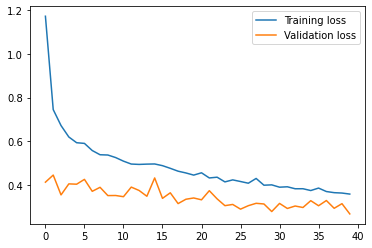

In [28]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(["Training loss", "Validation loss"])

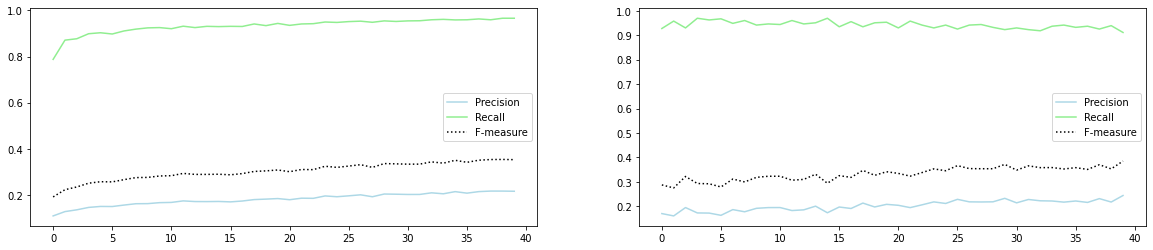

In [30]:
fig, axs = plt.subplots(1,2,figsize=(20,4))
# Prec. training
axs[0].plot([tp/(fp+tp) for (tp, fp) in zip(history['tp'], history['fp'])], color='lightblue')
# Rec. training
axs[0].plot([tp/(fn+tp) for (tp, fn) in zip(history['tp'], history['fn'])], color='lightgreen')
# F-measure
axs[0].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history['tp'], history['fp'], history['fn'])], 'k:')
axs[0].legend(["Precision", "Recall", "F-measure"])

# Prec. training
axs[1].plot([tp/(fp+tp) for (tp, fp) in zip(history['val_tp'], history['val_fp'])], color='lightblue')
# Rec. training
axs[1].plot([tp/(fn+tp) for (tp, fn) in zip(history['val_tp'], history['val_fn'])], color='lightgreen')
# F-measure
axs[1].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history['val_tp'], history['val_fp'], history['val_fn'])], 'k:')
axs[1].legend(["Precision", "Recall", "F-measure"])

## Audio analysis and onset extraction

In [35]:
F_RATE = HOP/SR 
train_idx = np.array([0,  1,  2,  4,  5,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18])
test_idx = np.array([3, 6, 10, 15])
test_idx = np.array([3])
test_audio_paths = ['datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{:02d}.wav'.format(test_index+1) for test_index in test_idx]
test_audios = [madmom.audio.signal.load_wave_file(path)[0] for path in test_audio_paths]
test_lengths = [len(test_audio)/SR for test_audio in test_audios]
test_onsets = [genfromtxt('datasets/initslurtest_vn/initslurtest_vn_annotations/{:02d}.txt'.format(test_index+1), delimiter=',') for test_index in test_idx]
test_onset_vectors = [get_label_vector(test_onset, len(test_audio)/SR, HOP, SR) for test_audio, test_onset in zip(test_audios, test_onsets)]
print("Test recordings: ", test_idx+1)
print("Length of recordings: ", ["{:.1f} s".format(l) for l in test_lengths])
print([len(a)/HOP for a in test_audios])
print("Length of onset vectors: ", [len(v) for v in test_onset_vectors])
print("Number of annotated onsets: ", 
    [len(test_onset) for test_onset in test_onsets], 
    " = ", np.sum([len(test_onset) for test_onset in test_onsets])
)

Test recordings:  [4]
Length of recordings:  ['16.0 s']
[1596.108843537415]
Length of onset vectors:  [1597]
Number of annotated onsets:  [75]  =  75


/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [36]:
full_audio = np.concatenate(test_audios)
cum_lengths = np.concatenate(([0.0], np.cumsum(test_lengths)))[:-1]
full_onsets = np.concatenate(
    [shift + onset for (shift, onset) in zip(cum_lengths, test_onsets)]
)
full_onset_vectors = np.concatenate(test_onset_vectors)

In [37]:
X_train = np.concatenate([X[i] for i in train_idx]) 

center_frames_train = X_train[:,:,7,:]
mean_train = center_frames_train.mean(0).reshape((1,80,1,3))
std_train = center_frames_train.std(0, ddof=1).reshape((1,80,1,3))



KeyboardInterrupt: 

In [34]:

model = tf.keras.models.load_model('results/cnn-training-220331/{}_fold_{}_model'.format(0, training_name))
test_model_out = model.predict((-mean_train)/std_train)

In [95]:
KERNEL_SIZE = 5
N_PRE = 5
N_POST = 1
THRES = 0.5

test_peaks = madmom.features.onsets.peak_picking(
                                    activations=test_model_out, 
                                    threshold=THRES, 
                                    smooth=KERNEL_SIZE, 
                                    pre_avg=N_PRE, 
                                    post_avg=N_POST, 
                                    pre_max=N_PRE, 
                                    post_max=N_POST
)[0].astype(np.float32)*F_RATE

len(test_peaks)


416

[10.309999 10.84     11.38     11.96     12.45     13.03    ]


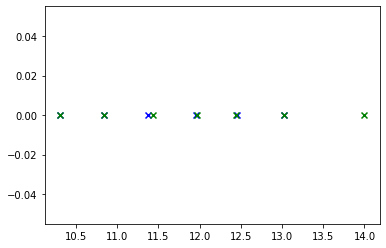

In [ ]:
start_sec = 10
end_sec = 14
selected_peaks = test_peaks[np.intersect1d(
    np.where(test_peaks>=start_sec)[0],
    np.where(test_peaks<end_sec)[0])
]
selected_onsets = full_onsets[np.intersect1d(
    np.where(full_onsets>=start_sec)[0],
    np.where(full_onsets<end_sec)[0])
]
print(selected_peaks)
plt.scatter(selected_peaks, np.zeros_like(selected_peaks), marker='x', color='blue')
plt.scatter(selected_onsets, np.zeros_like(selected_onsets), marker='x', color='green')

In [96]:
from analyze_detection import evaluate

true = full_onsets
pred = test_peaks

TOL = 0.025
[CD,FN,FP,doubles,merged] = evaluate(true, pred, tol_sec=TOL)
print(CD)
print("Precision: {:.1f} %".format( 100*CD/(CD+FP)))
print("Recall: {:.1f} %".format( 100*CD/(CD+FN)))
print("F-score: {:.1f} %".format( 200*CD/(2*CD+FP+FN)))

374
Precision: 89.9 %
Recall: 94.9 %
F-score: 92.3 %


In [82]:
start_sec = 30
dur_sec = 5

selected_audio = full_audio[start_sec*SR:(start_sec+dur_sec)*SR]
selected_onsets = full_onsets[np.intersect1d(
        np.where(full_onsets>=start_sec)[0], 
        np.where(full_onsets<start_sec+dur_sec)[0]
)]
selected_onehot = full_onset_vectors[int(start_sec/F_RATE):int((start_sec+dur_sec)/F_RATE)]
fig = plt.figure(figsize=(25,5))
if start_sec + dur_sec < len(full_audio)/SR:
    
    
    plt.plot(
        np.linspace(start_sec, start_sec+dur_sec, dur_sec*SR),
        selected_audio, 
        color="lightgray"
    )
    for i, onset in enumerate(selected_onehot):
        if onset==1:
            plt.scatter(start_sec + i*F_RATE/dur_sec, 0, color='green')
    plt.xlabel("Seconds")
    plt.show()

else:
    print("Cannot plot selected region, choose other start/dur values")

Cannot plot selected region, choose other start/dur values


<Figure size 1800x360 with 0 Axes>

0.01

Precision: 58.2 %
Recall: 61.5 %


In [ ]:
#f = open("datasets/initslurtest_vn/model-output/bockmodel-220315-slurtest{:02d}.txt".format(test_index), "w")
#for i in range(len(peaks)):
#    f.write(str(np.round((peaks[i]+7)*440/44100, decimals=2))+ "\n")
#f.close()